In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA

In [8]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita = aita_2.loc[:,['title_polarity','title_subjectivity','title_clean','is_asshole']]
aita.dropna(inplace=True)
aita.reset_index(drop=True)

,title_polarity,title_subjectivity,title_clean,is_asshole
0,0.0,0.0,I write an explanation in til and come off a...,1
1,0.0,0.0,throw my parent donut away,1
2,0.0,0.0,I tell a goth girl she look like a clown,0
3,0.0,0.0,argument I have with another redditor in rhimym,1
4,0.0,0.0,have a disagreement about le miserable with ...,1
...,...,...,...,...
97493,0.0,0.0,for tell my sister she be be a spoiled brat,0
97494,0.0,0.0,for tell my husband to f off after he relent...,0
97495,0.1,0.3,for attempt to keep my student out of adult ...,0
97496,0.0,0.0,if I leave my brother fate up to the state,0


## 1 - Save features X and labels y, train test split

In [9]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=11)

In [10]:
X_train.shape, X_test.shape

((96523, 3), (975, 3))

## 2 - Instantiate CountVectorizer 

In [26]:
stop = set(stopwords.words('english'))
vec = CountVectorizer(stop_words=stop, min_df=25, max_df=0.8, ngram_range=(1, 2))
cv = vec.fit(X_train['title_clean'])

In [27]:
len(vec.get_feature_names())

3215

#### Save fitted CountVectorizer to use later

In [11]:
# pickle.dump(cv, open('models/cv_fit_train.sav', 'wb'))

#### Load fitted CountVectorizer

In [6]:
# cv = pickle.load(open('models/cv_fit_train.sav', 'rb'))

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [28]:
cv_train = cv.transform(X_train['title_clean'])
cv_test = cv.transform(X_test['title_clean'])

In [29]:
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols)

In [30]:
train_word_count = dtm_train.sum(axis=0)
train_word_count.sort_values(ascending=False)[:10]

friend        16032
want          12914
tell          11576
get            7805
girlfriend     6115
ask            5764
go             5602
boyfriend      5065
sister         4131
mom            3904
dtype: int64

In [32]:
# ((96480, 44051), (975, 44051))
dtm_train.shape, dtm_test.shape

((96523, 3215), (975, 3215))

### Save / Load Document Term Matrix to / from csv

In [25]:
# dtm_train.to_csv('data/dtm_train.csv', index=False)
# dtm_test.to_csv('data/dtm_test.csv', index=False)

# dtm_train = pd.read_csv('data/dtm_train.csv')
# dtm_test = pd.read_csv('data/dtm_test.csv')

## 3 - PCA

In [33]:
pca = IncrementalPCA(n_components=800, batch_size=850)
pca.fit(dtm_train)
print(pca.explained_variance_ratio_.sum())

0.7919541496119181


### 3.a Scree plot, check number of components is appropriate

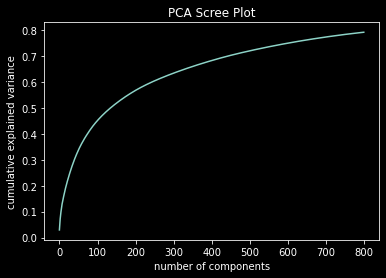

In [35]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Scree Plot')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

#### Save / Load fitted PCA Model

In [41]:
pickle.dump(pca, open('models/pca_title.sav', 'wb'))
# pca = pickle.load(open('models/pca.sav', 'rb'))
# pca

### 3.b - Transform train/test Document-Term-matrix with PCA

In [36]:
dtm_train_pca = pca.transform(dtm_train)
dtm_test_pca = pca.transform(dtm_test)

Build DataFrame of PCA Components

In [37]:
col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names)
dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names)

Combine PCA components and sentiment analysis scores into one DataFrame

In [38]:
X_train_post_dtm_pca = pd.concat([X_train[['title_polarity','title_subjectivity']].reset_index(drop=True), dtm_train_pca_df], axis=1)
X_test_post_dtm_pca = pd.concat([X_test[['title_polarity','title_subjectivity']].reset_index(drop=True),dtm_test_pca_df], axis=1)

In [39]:
X_train_post_dtm_pca.head()

,title_polarity,title_subjectivity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_791,PC_792,PC_793,PC_794,PC_795,PC_796,PC_797,PC_798,PC_799,PC_800
0,0.214286,0.571429,0.765371,0.047379,-0.324399,-0.110045,-0.063606,0.072773,-0.063522,-0.058488,...,0.020670,0.006495,0.000779,0.004055,0.001104,-0.012162,-0.032745,0.013820,-0.008665,-0.006860
1,0.000000,0.000000,-0.256039,0.837627,0.227405,-0.020942,-0.103116,-0.108455,-0.075996,-0.082632,...,0.004513,-0.070951,-0.011805,-0.013903,-0.035777,-0.022711,-0.007931,0.046720,0.020402,-0.018136
2,0.136364,0.454545,-0.278638,0.834051,0.278272,0.078694,-0.323229,-0.157492,0.299397,0.838329,...,0.015474,0.028356,0.083720,-0.186573,-0.002924,-0.056574,-0.035236,0.028555,-0.014242,-0.006378
3,-0.500000,1.000000,-0.174513,-0.188146,-0.167346,0.967915,-0.082202,0.033708,-0.031101,-0.056101,...,0.016674,0.005514,0.003768,0.020671,-0.000444,-0.028164,-0.012900,-0.004935,-0.004395,0.017247
4,0.000000,0.000000,-0.179439,-0.097769,-0.121194,-0.088063,-0.061407,0.002481,-0.092915,0.000052,...,-0.003317,0.000521,-0.004525,0.002273,0.002001,-0.001088,0.005236,-0.004954,0.003370,-0.002061


In [40]:
print(X_train_post_dtm_pca.shape, y_train.shape)
print(X_test_post_dtm_pca.shape, y_test.shape)

(96523, 802) (96523,)
(975, 802) (975,)


# Models

## 1 - Random Forest Models

### 1.a Vanilla Random Forest, no tuning hyperparameters 

In [49]:
rfc = RandomForestClassifier()
rfc.fit(X_train_post_dtm_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
cross_val_score(rfc, X_train_post_dtm_pca, y_train, cv=5, scoring='f1')

array([0.01932008, 0.01416853, 0.00824279, 0.01418704, 0.0134882 ])

In [54]:
print(f'Testing Accuracy = {rfc.score(X_test_post_dtm_pca, y_test)}')

Testing Accuracy = 0.7271794871794872


In [97]:
y_pred_train = rfc.predict(X_train_post_dtm_pca)
print(confusion_matrix(y_train,y_pred_train))
# print(classification_report(y_train,y_pred_train))
print(f'F1 Score = {f1_score(y_train,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train)}')

[[70299     0]
 [    0 26181]]
F1 Score = 1.0
Accuracy Score = 1.0


In [96]:
y_pred_test = rfc.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test))
# print(classification_report(y_test,y_pred_test))
print(f'F1 Score = {f1_score(y_test,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test)}')

[[707   3]
 [263   2]]
F1 Score = 0.014814814814814815
Accuracy Score = 0.7271794871794872


### 1.b weighted random forest

In [ ]:
rfc2 = RandomForestClassifier(class_weight="balanced")
rfc2.fit(X_train_post_dtm_pca, y_train)

In [ ]:
y_pred_train_2 = rfc2.predict(X_train_post_dtm_pca)
print(confusion_matrix(y_train,y_pred_train_2))
# print(classification_report(y_train,y_pred_train_2))
print(f'F1 Score = {f1_score(y_train,y_pred_train_2)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train_2)}')

In [ ]:
y_pred_test_2 = rfc2.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_2))
# print(classification_report(y_test,y_pred_test_2))
print(f'F1 Score = {f1_score(y_test,y_pred_test_2)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_2)}')

## 2 - Logistic Regression

In [41]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_post_dtm_pca, y_train)

LogisticRegression(class_weight='balanced')

In [42]:
y_pred_train_lr = lr.predict(X_train_post_dtm_pca)
print(confusion_matrix(y_train,y_pred_train_lr))
# print(classification_report(y_train,y_pred_train_lr))
print(f'F1 Score = {f1_score(y_train,y_pred_train_lr)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train_lr)}')

[[41532 28801]
 [10422 15768]]
F1 Score = 0.44568182139374496
Accuracy Score = 0.5936408938802151


In [43]:
y_pred_test_lr = lr.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_lr))
# print(classification_report(y_test,y_pred_test_lr))
print(f'F1 Score = {f1_score(y_test,y_pred_test_lr)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_lr)}')

[[404 306]
 [108 157]]
F1 Score = 0.4313186813186813
Accuracy Score = 0.5753846153846154


## 3. Naive Bayes

In [82]:
nb = MultinomialNB()
nb.fit(dtm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [100]:
y_pred_train_nb = nb.predict(dtm_train)
print(confusion_matrix(y_train,y_pred_train_nb))
# print(classification_report(y_train,y_pred_train_nb))
print(f'F1 Score = {f1_score(y_train,y_pred_train_nb)}')
print(f'Accuracy Score = {accuracy_score(y_train,y_pred_train_nb)}')

[[46942 23357]
 [12704 13477]]
F1 Score = 0.4277394271205268
Accuracy Score = 0.626233416252073


In [101]:
y_pred_test_nb = nb.predict(dtm_test)
print(confusion_matrix(y_test,y_pred_test_nb))
# print(classification_report(y_test,y_pred_test_nb))
print(f'F1 Score = {f1_score(y_test,y_pred_test_nb)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_nb)}')

[[462 248]
 [139 126]]
F1 Score = 0.39436619718309857
Accuracy Score = 0.6030769230769231
